### 필요한 라이브러리 import

In [7]:
import keras
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import more_itertools as mit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Dense,LSTM
warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)

### LSTM AE Model

In [8]:
""" LSTM encoder """
class Encoder(Model):

    def __init__(self, seq_length, latent_dim):
        super(Encoder, self).__init__()

        self.h1 = LSTM(256, return_sequences=True)  # (seq_len, input_dim) -> (seq_len, 256))
        self.h2 = LSTM(128, return_sequences=True) # (seq_len , 256) -> (seq_len , 128)
        self.h2 = LSTM(64, return_sequences=True) # (seq_len , 128) -> (seq_len , 64)
        self.h3 = LSTM(latent_dim, return_sequences=False) # (seq_len , 54) -> (latent_dim)
        self.h4 = RepeatVector(seq_length) # (latent_dim) -> (seq_length, latent_dim)

    def call(self, x):
        x = self.h1(x)
        z = self.h2(x)
        k = self.h3(z)
        k_rep = self.h4(k)

        return k, k_rep

""" LSTM dncoder """
class Decoder(Model):

    def __init__(self, input_dim, latent_dim):
        super(Decoder, self).__init__()

        self.h1 = LSTM(latent_dim, return_sequences=True) # (seq_length, latent_dim) -> (seq_len, input_dim)
        self.h2 = LSTM(64, return_sequences=True) # (seq_len, input_dim) -> (seq_length, 64)
        self.h2 = LSTM(128, return_sequences=True) # (seq_len, input_dim) -> (seq_length, 128)
        self.h3 = LSTM(256, return_sequences=True) # (seq_len, input_dim) -> (seq_length, 256)
        self.h4 = TimeDistributed(Dense(input_dim)) # (seq_length, 128) -> (seq_length, input_dim)

    def call(self, x):
        x = self.h1(x)
        x = self.h2(x)
        x = self.h3(x)
        x = self.h4(x)

        return x


""" LSTM AE """
class LstmAE(Model):

    def __init__(self, seq_length, input_dim, latent_dim):
        super(LstmAE, self).__init__()

        self.encoder = Encoder(seq_length, latent_dim)
        self.decoder = Decoder(input_dim, latent_dim)

    def call(self, x):
        z, z_rep = self.encoder(x)
        decoded = self.decoder(z_rep)

        return decoded

### make window size method

In [9]:
def to_sequences(x, seq_len=1):

    X = []

    for i in range(len(x) - seq_len):
        X.append(x.iloc[i:(i + seq_len)].values)

    return np.array(X)

In [10]:
config ={}
config['seq_len'] = 30
config['latent_dim'] = 20

def to_sequences(x, seq_len=1):

    X = []

    for i in range(len(x) - seq_len):
        X.append(x.iloc[i:(i + seq_len)].values)

    return np.array(X)

### data setting

In [14]:
data = pd.read_csv("nyc_taxi.csv")
data["value"] = data["value"].astype("float32")
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.head(3)

,timestamp,value
0,2014-07-01 00:00:00,10844.0
1,2014-07-01 00:30:00,8127.0
2,2014-07-01 01:00:00,6210.0


### dynamic threshold method

In [15]:
def find_epsilon(error,sd_lim,start = 0.1,term = 0.1,inverse=False):

    e_mean = np.mean(error)
    e_std = np.std(error)
    pruned_e_s = []
    sd_threshold = None
    sd_epsilon = None

    max_score = -10000000
    
    for z in np.arange(2.5, sd_lim, term):
        epsilon = e_mean + (e_std * z)
        # print(epsilon)
        for j in range(len(error)):
            if error[j] < epsilon:
                pruned_e_s.append(error[j])

        i_anom = []
        for j in range(len(error)):
            if error[j] >= epsilon:
                i_anom.append(error[j])
        if len(i_anom) > 0:
            groups = [list(group) for group
                        in mit.consecutive_groups(i_anom)]
            E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]

            mean_perc_decrease = (e_mean - np.mean(pruned_e_s)) \
                                    / e_mean
            sd_perc_decrease = (e_std - np.std(pruned_e_s)) \
                                / e_std
            score = (mean_perc_decrease + sd_perc_decrease) \
                    / (len(E_seq) ** 2 + len(i_anom))

            # sanity checks / guardrails
            if score >= max_score \
                and len(E_seq) <= 5 and \
                    len(i_anom) < (len(error) * 0.5):
                max_score = score
                sd_threshold = z
                sd_epsilon = e_mean + z * e_std
        
    return sd_epsilon

### Training setting

In [20]:
config ={}
config['seq_len'] = 30 # window size
config['latent_dim'] = 20 # latent vector
config['batch_size'] = 1 # batsize : real time이므로 1로 설정
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

seq_len = config['seq_len']
latent_dim = config['latent_dim']
batch_size = config['batch_size']

input_dim = to_sequences(data.iloc[:seq_len+1][['value']], seq_len).shape[2]
lstm_ae = LstmAE(seq_len, input_dim, latent_dim)
lstm_ae.compile(optimizer=optimizer, loss='mse')

dis = [] # error 값 리스트
dot = [] # 이상치 index 리스트

limit = 10 # dynamic threshold z값의 limit

smoothing_window = int(batch_size * seq_len * 0.05)
th_history = [] # threshold 변화값 list
Threshold = None

temp_epsilon = np.inf

### Real Time Training Simulation

In [21]:
for i in range(len(data)):
    if i < seq_len+1:
        dot.append(-1)
        continue

    # 예측 데이터 및 학습 데이터 구성
    sample_data = copy.deepcopy(data.iloc[:i+1])
    scaler = StandardScaler()
    scaler = scaler.fit(sample_data[["value"]])
    seq_len = config['seq_len']
    latent_dim = config['latent_dim']
    sample_data.loc[:, "value"] = scaler.transform(sample_data[["value"]]).reshape(-1).copy()
    trainX = to_sequences(sample_data.iloc[i-31:i+1][['value']], seq_len)
    
    pred = lstm_ae.predict(trainX)

    # error값 계산 및 저장
    result = [None for i in range(seq_len)]
    for j in pred:
        result.append(j[-1][0])
    curr_dis = abs(sample_data.iloc[-1]["value"] - result[-1])
    dis.append(curr_dis)

    # 학습이 충분히 된 다음에 dynamic threshold를 구한다.
    if len(dis) > 1000:
        e_s = pd.DataFrame(dis[-1000:]).ewm(span=smoothing_window).mean().values.flatten()
        Threshold = find_epsilon(e_s,limit,start=2,term=0.5)

        if Threshold == None:
            Threshold = temp_epsilon
        else:
            temp_epsilon = Threshold

        th_history.append(Threshold)
    
    # 초기 threshold의 값은 None값이므로 예외처리
    if Threshold == None:
        dot.append(-1)
        history = lstm_ae.fit(trainX, trainX, epochs=1, verbose=0)
        continue

    # 만약 threshold 보다 큰 error가 존재한다면 이상치라고 판단
    if curr_dis > Threshold:
        dot.append(i)
    else:
        history = lstm_ae.fit(trainX, trainX, epochs=1, verbose=0)
        dot.append(-1)

    if i%1000 == 0:
        print("{}번째 epochs, loss : {} ".format(i,history.history["loss"]))


2000번째 epochs, loss : [0.743665874004364] 
3000번째 epochs, loss : [0.4986557066440582] 
4000번째 epochs, loss : [1.124130368232727] 
5000번째 epochs, loss : [0.7287260890007019] 
6000번째 epochs, loss : [0.7361255288124084] 
7000번째 epochs, loss : [0.7683420181274414] 
8000번째 epochs, loss : [1.2640284299850464] 
9000번째 epochs, loss : [0.8686745762825012] 
10000번째 epochs, loss : [1.140019178390503] 


### 데이터 시각화

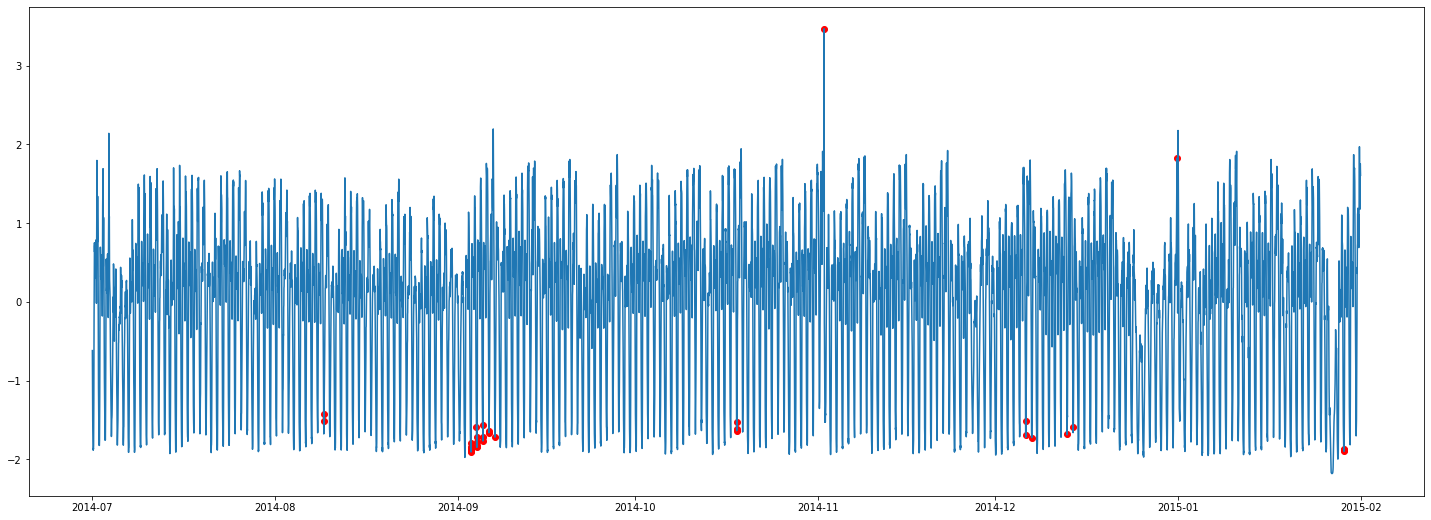

In [22]:
plt.figure(figsize=(25,9))
plt.plot(sample_data.timestamp,sample_data.value)
for i in range(len(sample_data)):
    if dot[i] != -1:
        plt.scatter(sample_data.iloc[i].timestamp,sample_data.iloc[i].value,color="red")

### error 곡선과 threshold 곡선 시각화

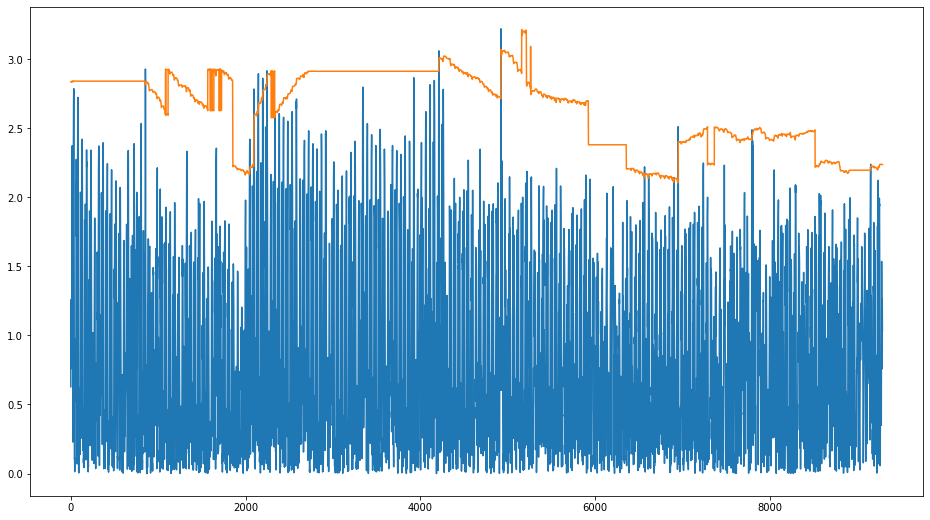

In [23]:
plt.figure(figsize=(16,9))
plt.plot(dis[1000:])
plt.plot(th_history)